# Embedding Generation Notebook

This notebook generates vector representations for different types of chunks:
- **Text chunks**: Using `sentence-transformers/all-MiniLM-L6-v2` (384 dimensions)
- **Table chunks**: Using `sentence-transformers/all-MiniLM-L6-v2` (384 dimensions)
- **Image chunks**: Using `CLIP` (512 dimensions for ViT-B/32)

## Features
- Fast text embeddings with MiniLM
- Multimodal image embeddings with CLIP
- Batch processing for efficiency
- Progress tracking
- Embedding storage with metadata


## 1. Installation and Imports


In [6]:

#!pip install ftfy regex tqdm



In [1]:
import json
import os
import numpy as np
from pathlib import Path
from typing import List, Dict, Any
from tqdm import tqdm
import torch
from PIL import Image
from datetime import datetime

# Sentence Transformers for text embeddings
from sentence_transformers import SentenceTransformer

# CLIP for image embeddings
import clip

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


c:\Users\hashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. Configuration


In [2]:
# Paths
METADATA_DIR = "extracted_data/metadata"
EMBEDDINGS_DIR = "extracted_data/embeddings"
CHARTS_DIR = "extracted_data/charts"

# Create embeddings directory
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

# Input files
TEXT_CHUNKS_FILE = os.path.join(METADATA_DIR, "text_chunks.json")
TABLE_CHUNKS_FILE = os.path.join(METADATA_DIR, "table_chunks.json")
IMAGE_CHUNKS_FILE = os.path.join(METADATA_DIR, "image_chunks.json")

# Output files
TEXT_EMBEDDINGS_FILE = os.path.join(EMBEDDINGS_DIR, "text_embeddings.npy")
TEXT_METADATA_FILE = os.path.join(EMBEDDINGS_DIR, "text_embeddings_metadata.json")

TABLE_EMBEDDINGS_FILE = os.path.join(EMBEDDINGS_DIR, "table_embeddings.npy")
TABLE_METADATA_FILE = os.path.join(EMBEDDINGS_DIR, "table_embeddings_metadata.json")

IMAGE_EMBEDDINGS_FILE = os.path.join(EMBEDDINGS_DIR, "image_embeddings.npy")
IMAGE_METADATA_FILE = os.path.join(EMBEDDINGS_DIR, "image_embeddings_metadata.json")

# Model configurations
TEXT_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
CLIP_MODEL_NAME = "ViT-B/32"  # 512 dimensions

# Processing parameters
BATCH_SIZE_TEXT = 32
BATCH_SIZE_IMAGE = 16

print(f"Text chunks file: {TEXT_CHUNKS_FILE}")
print(f"Table chunks file: {TABLE_CHUNKS_FILE}")
print(f"Image chunks file: {IMAGE_CHUNKS_FILE}")
print(f"Embeddings directory: {EMBEDDINGS_DIR}")


Text chunks file: extracted_data/metadata\text_chunks.json
Table chunks file: extracted_data/metadata\table_chunks.json
Image chunks file: extracted_data/metadata\image_chunks.json
Embeddings directory: extracted_data/embeddings


## 3. Load Models


In [3]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load text embedding model
print(f"\nLoading text embedding model: {TEXT_MODEL_NAME}...")
text_model = SentenceTransformer(TEXT_MODEL_NAME, device=device)
print(f"Text model loaded. Embedding dimension: {text_model.get_sentence_embedding_dimension()}")

# Load CLIP model for images
print(f"\nLoading CLIP model: {CLIP_MODEL_NAME}...")
clip_model, clip_preprocess = clip.load(CLIP_MODEL_NAME, device=device)
print(f"CLIP model loaded. Embedding dimension: 512")


Using device: cuda

Loading text embedding model: sentence-transformers/all-MiniLM-L6-v2...


c:\Users\hashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Text model loaded. Embedding dimension: 384

Loading CLIP model: ViT-B/32...
CLIP model loaded. Embedding dimension: 512


## 4. Load Chunk Data


In [4]:
def load_chunks(file_path: str) -> List[Dict[str, Any]]:
    """Load chunks from JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        chunks = json.load(f)
    return chunks

# Load all chunks
print("Loading chunks...")
text_chunks = load_chunks(TEXT_CHUNKS_FILE)
table_chunks = load_chunks(TABLE_CHUNKS_FILE)
image_chunks = load_chunks(IMAGE_CHUNKS_FILE)

print(f"\nLoaded:")
print(f"  - {len(text_chunks)} text chunks")
print(f"  - {len(table_chunks)} table chunks")
print(f"  - {len(image_chunks)} image chunks")
print(f"  - Total: {len(text_chunks) + len(table_chunks) + len(image_chunks)} chunks")


Loading chunks...

Loaded:
  - 526 text chunks
  - 114 table chunks
  - 73 image chunks
  - Total: 713 chunks


## 5. Generate Text Embeddings

Generate embeddings for text chunks using the all-MiniLM-L6-v2 model.


In [5]:
def generate_text_embeddings(chunks: List[Dict[str, Any]], 
                            model: SentenceTransformer, 
                            batch_size: int = 32) -> np.ndarray:
    """Generate embeddings for text chunks."""
    
    texts = [chunk['content'] for chunk in chunks]
    
    print(f"Generating embeddings for {len(texts)} texts...")
    embeddings = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True  # L2 normalization for cosine similarity
    )
    
    return embeddings

# Generate text embeddings
print("=" * 80)
print("GENERATING TEXT EMBEDDINGS")
print("=" * 80)

text_embeddings = generate_text_embeddings(
    text_chunks, 
    text_model, 
    batch_size=BATCH_SIZE_TEXT
)

print(f"\nText embeddings shape: {text_embeddings.shape}")
print(f"Embedding dimension: {text_embeddings.shape[1]}")
print(f"Memory size: {text_embeddings.nbytes / (1024**2):.2f} MB")


GENERATING TEXT EMBEDDINGS
Generating embeddings for 526 texts...


Batches: 100%|██████████| 17/17 [00:00<00:00, 17.09it/s]


Text embeddings shape: (526, 384)
Embedding dimension: 384
Memory size: 0.77 MB


In [6]:
# Save text embeddings
print("\nSaving text embeddings...")
np.save(TEXT_EMBEDDINGS_FILE, text_embeddings)

# Create metadata
text_metadata = {
    "embedding_model": TEXT_MODEL_NAME,
    "embedding_dimension": int(text_embeddings.shape[1]),
    "num_embeddings": int(text_embeddings.shape[0]),
    "normalized": True,
    "generation_date": datetime.now().isoformat(),
    "chunk_ids": [chunk['chunk_id'] for chunk in text_chunks],
    "source_files": list(set([chunk['source_file'] for chunk in text_chunks])),
    "chunk_metadata": [
        {
            "chunk_id": chunk['chunk_id'],
            "source_file": chunk['source_file'],
            "page_number": chunk['page_number'],
            "word_count": chunk['word_count'],
            "has_financial_data": chunk.get('has_financial_data', False)
        }
        for chunk in text_chunks
    ]
}

with open(TEXT_METADATA_FILE, 'w', encoding='utf-8') as f:
    json.dump(text_metadata, f, indent=2)

print(f"Saved text embeddings to: {TEXT_EMBEDDINGS_FILE}")
print(f"Saved text metadata to: {TEXT_METADATA_FILE}")



Saving text embeddings...
Saved text embeddings to: extracted_data/embeddings\text_embeddings.npy
Saved text metadata to: extracted_data/embeddings\text_embeddings_metadata.json


## 6. Generate Table Embeddings

Generate embeddings for table chunks using the same text model.


In [7]:
# Generate table embeddings
print("=" * 80)
print("GENERATING TABLE EMBEDDINGS")
print("=" * 80)

table_embeddings = generate_text_embeddings(
    table_chunks, 
    text_model, 
    batch_size=BATCH_SIZE_TEXT
)

print(f"\nTable embeddings shape: {table_embeddings.shape}")
print(f"Embedding dimension: {table_embeddings.shape[1]}")
print(f"Memory size: {table_embeddings.nbytes / (1024**2):.2f} MB")


GENERATING TABLE EMBEDDINGS
Generating embeddings for 114 texts...


Batches: 100%|██████████| 4/4 [00:00<00:00, 16.06it/s]


Table embeddings shape: (114, 384)
Embedding dimension: 384
Memory size: 0.17 MB


In [8]:
# Save table embeddings
print("\nSaving table embeddings...")
np.save(TABLE_EMBEDDINGS_FILE, table_embeddings)

# Create metadata
table_metadata = {
    "embedding_model": TEXT_MODEL_NAME,
    "embedding_dimension": int(table_embeddings.shape[1]),
    "num_embeddings": int(table_embeddings.shape[0]),
    "normalized": True,
    "generation_date": datetime.now().isoformat(),
    "chunk_ids": [chunk['chunk_id'] for chunk in table_chunks],
    "source_files": list(set([chunk['source_file'] for chunk in table_chunks])),
    "chunk_metadata": [
        {
            "chunk_id": chunk['chunk_id'],
            "source_file": chunk['source_file'],
            "page_number": chunk['page_number'],
            "num_rows": chunk.get('num_rows', 0),
            "num_cols": chunk.get('num_cols', 0),
            "has_financial_data": chunk.get('has_financial_data', False)
        }
        for chunk in table_chunks
    ]
}

with open(TABLE_METADATA_FILE, 'w', encoding='utf-8') as f:
    json.dump(table_metadata, f, indent=2)

print(f"Saved table embeddings to: {TABLE_EMBEDDINGS_FILE}")
print(f"Saved table metadata to: {TABLE_METADATA_FILE}")



Saving table embeddings...
Saved table embeddings to: extracted_data/embeddings\table_embeddings.npy
Saved table metadata to: extracted_data/embeddings\table_embeddings_metadata.json


## 7. Generate Image Embeddings with CLIP

Generate multimodal embeddings for image chunks using CLIP's vision encoder.


In [9]:
def generate_image_embeddings(chunks: List[Dict[str, Any]], 
                             model, 
                             preprocess,
                             device: str,
                             batch_size: int = 16) -> tuple:
    """
    Generate embeddings for image chunks using CLIP.
    
    IMPORTANT: This uses the ACTUAL IMAGE FILES (not OCR text)!
    - Loads the image from disk using PIL
    - Processes the visual content (pixels) with CLIP
    - Creates embeddings from visual features
    - OCR text in metadata is separate and not used here
    """
    
    embeddings_list = []
    failed_images = []
    
    print(f"Generating embeddings for {len(chunks)} images...")
    print("Note: Using ACTUAL image files (visual content), not OCR text!\n")
    
    # Process in batches
    for i in tqdm(range(0, len(chunks), batch_size), desc="Processing images"):
        batch_chunks = chunks[i:i+batch_size]
        batch_images = []
        batch_indices = []
        
        # Load and preprocess ACTUAL IMAGES (not text!)
        for idx, chunk in enumerate(batch_chunks):
            try:
                # Get path to the actual image file
                image_path = chunk['image_path']
                # Handle both forward and backward slashes
                image_path = image_path.replace('\\', os.sep).replace('/', os.sep)
                
                if not os.path.exists(image_path):
                    raise FileNotFoundError(f"Image not found: {image_path}")
                
                # Load the ACTUAL IMAGE PIXELS from file
                image = Image.open(image_path).convert('RGB')  # ← Real image!
                
                # Preprocess image for CLIP (resize, normalize pixels, etc.)
                image_tensor = preprocess(image)  # ← Visual preprocessing
                batch_images.append(image_tensor)
                batch_indices.append(i + idx)
            except Exception as e:
                print(f"\nError loading image {chunk.get('chunk_id', 'unknown')}: {e}")
                failed_images.append({
                    'chunk_id': chunk.get('chunk_id', 'unknown'),
                    'error': str(e)
                })
        
        if not batch_images:
            continue
        
        # Stack images and move to device
        batch_tensor = torch.stack(batch_images).to(device)
        
        # Generate embeddings from VISUAL CONTENT using CLIP's vision encoder
        with torch.no_grad():
            # CLIP processes the image pixels through its vision transformer
            image_features = model.encode_image(batch_tensor)  # ← Vision encoding!
            # Normalize embeddings for cosine similarity
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            embeddings_list.append(image_features.cpu().numpy())
    
    if failed_images:
        print(f"\nWarning: {len(failed_images)} images failed to process")
    
    # Concatenate all embeddings
    embeddings = np.vstack(embeddings_list)
    
    return embeddings, failed_images

# Generate image embeddings
print("=" * 80)
print("GENERATING IMAGE EMBEDDINGS WITH CLIP")
print("=" * 80)

image_embeddings, failed_images = generate_image_embeddings(
    image_chunks,
    clip_model,
    clip_preprocess,
    device,
    batch_size=BATCH_SIZE_IMAGE
)

print(f"\nImage embeddings shape: {image_embeddings.shape}")
print(f"Embedding dimension: {image_embeddings.shape[1]}")
print(f"Memory size: {image_embeddings.nbytes / (1024**2):.2f} MB")
print(f"Successfully processed: {image_embeddings.shape[0]} / {len(image_chunks)} images")


GENERATING IMAGE EMBEDDINGS WITH CLIP
Generating embeddings for 73 images...
Note: Using ACTUAL image files (visual content), not OCR text!



Processing images: 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]


Image embeddings shape: (73, 512)
Embedding dimension: 512
Memory size: 0.07 MB
Successfully processed: 73 / 73 images


In [10]:
# Save image embeddings
print("\nSaving image embeddings...")
np.save(IMAGE_EMBEDDINGS_FILE, image_embeddings)

# Create metadata
image_metadata = {
    "embedding_model": f"CLIP-{CLIP_MODEL_NAME}",
    "embedding_dimension": int(image_embeddings.shape[1]),
    "num_embeddings": int(image_embeddings.shape[0]),
    "normalized": True,
    "generation_date": datetime.now().isoformat(),
    "failed_images": failed_images,
    "chunk_ids": [chunk['chunk_id'] for chunk in image_chunks],
    "source_files": list(set([chunk['source_file'] for chunk in image_chunks])),
    "chunk_metadata": [
        {
            "chunk_id": chunk['chunk_id'],
            "source_file": chunk['source_file'],
            "page_number": chunk['page_number'],
            "image_type": chunk.get('image_type', 'unknown'),
            "has_text": chunk.get('has_text', False),
            "dimensions": chunk.get('dimensions', {}),
            "ocr_text_available": bool(chunk.get('ocr_text', '')),  # OCR is metadata only!
        }
        for chunk in image_chunks
    ]
}

with open(IMAGE_METADATA_FILE, 'w', encoding='utf-8') as f:
    json.dump(image_metadata, f, indent=2)

print(f"Saved image embeddings to: {IMAGE_EMBEDDINGS_FILE}")
print(f"Saved image metadata to: {IMAGE_METADATA_FILE}")

# Quick verification: Show what was embedded
print("\n" + "=" * 80)
print("EMBEDDING SOURCE VERIFICATION")
print("=" * 80)
print("\n✓ Text Embeddings: From text content strings")
print("✓ Table Embeddings: From table content strings")
print("✓ Image Embeddings: From VISUAL CONTENT of image files (not OCR text!)")
print(f"\nExample image embedded: {image_chunks[0]['image_path']}")
if image_chunks[0].get('ocr_text'):
    print(f"  - Has OCR text: Yes (but NOT used for embedding)")
    print(f"  - OCR preview: {image_chunks[0]['ocr_text'][:100]}...")
print(f"  - Embedding created from: VISUAL PIXELS of the image")



Saving image embeddings...
Saved image embeddings to: extracted_data/embeddings\image_embeddings.npy
Saved image metadata to: extracted_data/embeddings\image_embeddings_metadata.json

EMBEDDING SOURCE VERIFICATION

✓ Text Embeddings: From text content strings
✓ Table Embeddings: From table content strings
✓ Image Embeddings: From VISUAL CONTENT of image files (not OCR text!)

Example image embedded: extracted_data\charts\1. Annual Report 2023-24_page11_chart1.png
  - Has OCR text: Yes (but NOT used for embedding)
  - OCR preview: S#

Degree program

Programs Offered and Campuses

CFD ISB KHI LHR PWR
Bachelor’s degree programs
1 ...
  - Embedding created from: VISUAL PIXELS of the image


## 8. Generate Summary Statistics


In [11]:
# Summary of all embeddings
summary = {
    "generation_date": datetime.now().isoformat(),
    "text_embeddings": {
        "model": TEXT_MODEL_NAME,
        "count": int(text_embeddings.shape[0]),
        "dimension": int(text_embeddings.shape[1]),
        "file": TEXT_EMBEDDINGS_FILE,
        "metadata_file": TEXT_METADATA_FILE
    },
    "table_embeddings": {
        "model": TEXT_MODEL_NAME,
        "count": int(table_embeddings.shape[0]),
        "dimension": int(table_embeddings.shape[1]),
        "file": TABLE_EMBEDDINGS_FILE,
        "metadata_file": TABLE_METADATA_FILE
    },
    "image_embeddings": {
        "model": f"CLIP-{CLIP_MODEL_NAME}",
        "count": int(image_embeddings.shape[0]),
        "dimension": int(image_embeddings.shape[1]),
        "file": IMAGE_EMBEDDINGS_FILE,
        "metadata_file": IMAGE_METADATA_FILE,
        "failed_count": len(failed_images)
    },
    "total_embeddings": int(text_embeddings.shape[0] + table_embeddings.shape[0] + image_embeddings.shape[0]),
    "total_size_mb": float((text_embeddings.nbytes + table_embeddings.nbytes + image_embeddings.nbytes) / (1024**2))
}

# Save summary
summary_file = os.path.join(EMBEDDINGS_DIR, "embedding_summary.json")
with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)

print("\n" + "=" * 80)
print("EMBEDDING GENERATION SUMMARY")
print("=" * 80)
print(f"\nText Embeddings:")
print(f"  Model: {TEXT_MODEL_NAME}")
print(f"  Count: {text_embeddings.shape[0]}")
print(f"  Dimension: {text_embeddings.shape[1]}")
print(f"\nTable Embeddings:")
print(f"  Model: {TEXT_MODEL_NAME}")
print(f"  Count: {table_embeddings.shape[0]}")
print(f"  Dimension: {table_embeddings.shape[1]}")
print(f"\nImage Embeddings:")
print(f"  Model: CLIP-{CLIP_MODEL_NAME}")
print(f"  Count: {image_embeddings.shape[0]}")
print(f"  Dimension: {image_embeddings.shape[1]}")
print(f"  Failed: {len(failed_images)}")
print(f"\nTotal Embeddings: {summary['total_embeddings']}")
print(f"Total Size: {summary['total_size_mb']:.2f} MB")
print(f"\nSummary saved to: {summary_file}")



EMBEDDING GENERATION SUMMARY

Text Embeddings:
  Model: sentence-transformers/all-MiniLM-L6-v2
  Count: 526
  Dimension: 384

Table Embeddings:
  Model: sentence-transformers/all-MiniLM-L6-v2
  Count: 114
  Dimension: 384

Image Embeddings:
  Model: CLIP-ViT-B/32
  Count: 73
  Dimension: 512
  Failed: 0

Total Embeddings: 713
Total Size: 1.01 MB

Summary saved to: extracted_data/embeddings\embedding_summary.json


## 9. Verification and Testing


In [12]:
# Test similarity search
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """Compute cosine similarity between two vectors."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Test text similarity
print("Testing text embeddings...")
test_texts = [
    "university campus facilities",
    "computer science program",
    "financial report"
]

test_embeddings = text_model.encode(test_texts, normalize_embeddings=True)

for i, test_text in enumerate(test_texts):
    # Find most similar text chunk
    similarities = np.dot(text_embeddings, test_embeddings[i])
    top_idx = np.argmax(similarities)
    
    print(f"\nQuery: '{test_text}'")
    print(f"Most similar chunk (score: {similarities[top_idx]:.4f}):")
    print(f"  Chunk ID: {text_chunks[top_idx]['chunk_id']}")
    print(f"  Content preview: {text_chunks[top_idx]['content'][:150]}...")
    print(f"  Source: {text_chunks[top_idx]['source_file']} (Page {text_chunks[top_idx]['page_number']})")


Testing text embeddings...

Query: 'university campus facilities'
Most similar chunk (score: 0.5799):
  Chunk ID: 1. Annual Report 2023-24_text_401
  Content preview: facility is not yet possible due to shortage of space. For this, considerations have been made for incorporation in updated master plan of the campus....
  Source: 1. Annual Report 2023-24.pdf (Page 85)

Query: 'computer science program'
Most similar chunk (score: 0.5554):
  Chunk ID: 3. FYP-Handbook-2023_text_76
  Content preview: BS Final Year Project Handbook 2023
National University
of Computer & Emerging Sciences, [Campus]...
  Source: 3. FYP-Handbook-2023.pdf (Page 61)

Query: 'financial report'
Most similar chunk (score: 0.6391):
  Chunk ID: 2. financials_text_42
  Content preview: PwC | Basic Understanding of a Company's Financials
The benefits of an annual report
The annual report contains a significant amount of information:
F...
  Source: 2. financials.pdf (Page 32)


In [19]:
# Test CLIP text-to-image search
print("\nTesting CLIP text-to-image search...")
test_queries = [
    "table with numbers and data",
    "educational program information",
    "statistics and charts"
]

for query in test_queries:
    # Encode text query with CLIP
    text_tokens = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.cpu().numpy()
    
    # Find most similar images
    similarities = np.dot(image_embeddings, text_features.T).squeeze()
    top_idx = np.argmax(similarities)
    
    print(f"\nQuery: '{query}'")
    print(f"Most similar image (score: {similarities[top_idx]:.4f}):")
    print(f"  Chunk ID: {image_chunks[top_idx]['chunk_id']}")
    print(f"  Image path: {image_chunks[top_idx]['image_path']}")
    print(f"  Image type: {image_chunks[top_idx].get('image_type', 'unknown')}")
    print(f"  Source: {image_chunks[top_idx]['source_file']} (Page {image_chunks[top_idx]['page_number']})")



Testing CLIP text-to-image search...

Query: 'table with numbers and data'
Most similar image (score: 0.3176):
  Chunk ID: 1. Annual Report 2023-24_chart_1_page74
  Image path: extracted_data\charts\1. Annual Report 2023-24_page74_chart1.png
  Image type: chart
  Source: 1. Annual Report 2023-24.pdf (Page 74)

Query: 'educational program information'
Most similar image (score: 0.2825):
  Chunk ID: 1. Annual Report 2023-24_chart_1_page12
  Image path: extracted_data\charts\1. Annual Report 2023-24_page12_chart1.png
  Image type: chart
  Source: 1. Annual Report 2023-24.pdf (Page 12)

Query: 'statistics and charts'
Most similar image (score: 0.2756):
  Chunk ID: 1. Annual Report 2023-24_chart_4_page66
  Image path: extracted_data\charts\1. Annual Report 2023-24_page66_chart4.png
  Image type: chart
  Source: 1. Annual Report 2023-24.pdf (Page 66)


## 10. Visualization of Embeddings (Optional)


In [ ]:
# Install visualization libraries
%pip install matplotlib scikit-learn umap-learn


Visualizing 500 text embeddings...
Running t-SNE...


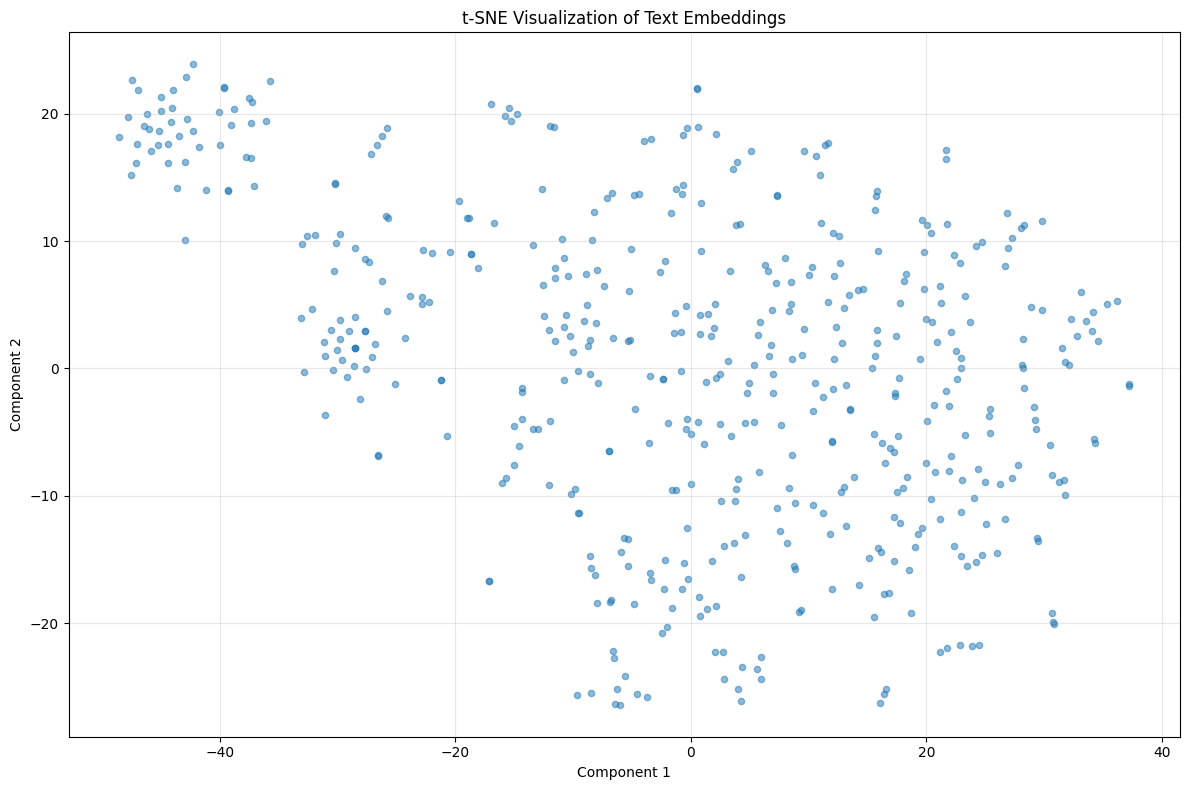

Saved t-SNE visualization to: extracted_data/embeddings\text_embeddings_tsne.png


In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Sample embeddings for visualization (use all if dataset is small)
sample_size = min(500, len(text_embeddings))
sample_indices = np.random.choice(len(text_embeddings), sample_size, replace=False)
sampled_text_embeddings = text_embeddings[sample_indices]

print(f"Visualizing {sample_size} text embeddings...")

# t-SNE visualization
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(sampled_text_embeddings)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, s=20)
plt.title('t-SNE Visualization of Text Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(EMBEDDINGS_DIR, 'text_embeddings_tsne.png'), dpi=150)
plt.show()

print(f"Saved t-SNE visualization to: {os.path.join(EMBEDDINGS_DIR, 'text_embeddings_tsne.png')}")


## 11. Final Summary


In [ ]:
print("\n" + "=" * 80)
print("EMBEDDING GENERATION COMPLETE!")
print("=" * 80)
print("\nGenerated Files:")
print(f"1. Text Embeddings:")
print(f"   - {TEXT_EMBEDDINGS_FILE}")
print(f"   - {TEXT_METADATA_FILE}")
print(f"\n2. Table Embeddings:")
print(f"   - {TABLE_EMBEDDINGS_FILE}")
print(f"   - {TABLE_METADATA_FILE}")
print(f"\n3. Image Embeddings:")
print(f"   - {IMAGE_EMBEDDINGS_FILE}")
print(f"   - {IMAGE_METADATA_FILE}")
print(f"\n4. Summary:")
print(f"   - {summary_file}")
print("\nNext Steps:")
print("1. Create a vector database (FAISS, Pinecone, Weaviate, or Chroma)")
print("2. Index embeddings for efficient similarity search")
print("3. Build a retrieval system (RAG - Retrieval Augmented Generation)")
print("4. Implement multimodal search (text-to-text, text-to-image, image-to-image)")
print("5. Create a question-answering system using the embeddings")
print("=" * 80)
